In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from var_model import ClimateVAR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
all_data

,AAPL,BEP,FSLR,GOOG,IBM,NEE,NVDA,TSLA,VWDRY,Temperature,DSCI,Coal,Natural Gas,Petroleum,Total CO2 Emissions,GDP,TB3MS,CPI
0,-0.071891,0.004221,-0.086066,-0.028478,-0.010668,0.018201,-0.043872,-0.090422,-0.017129,3.434062,104.00,-0.107713,-0.079697,0.035305,-0.045066,17912.079,0.02,237.430
1,0.061424,0.039767,-0.051121,0.015426,-0.044440,0.027754,-0.042394,-0.084574,0.078838,0.239178,103.25,-0.140308,-0.024601,0.005973,-0.049579,18063.529,0.03,234.747
2,0.100777,-0.030332,0.411862,0.044676,0.063701,-0.045986,0.153383,-0.001277,0.076154,0.835308,111.25,-0.117793,0.071572,0.034858,-0.002740,18063.529,0.03,234.747
3,-0.031372,0.026324,0.000669,-0.018625,-0.008892,0.005703,-0.051224,-0.071653,-0.007799,2.247921,117.20,-0.185240,0.017076,0.057500,-0.029565,18063.529,0.03,234.747
4,0.005786,0.032932,-0.002007,-0.016760,0.067227,-0.029986,0.060678,0.197489,0.094160,0.825789,125.25,-0.163193,0.027977,0.012721,-0.034143,18279.784,0.02,236.222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.113780,0.197978,0.107617,0.068795,0.108672,0.011769,0.146886,0.195379,0.282913,1.999337,124.75,-0.087308,0.020830,0.012984,-0.000491,27956.998,5.34,307.531
108,0.013582,0.060961,0.091900,0.052345,0.031471,0.038113,0.058934,0.034988,0.145197,2.834145,114.50,-0.225731,-0.062126,0.004378,-0.064475,27956.998,5.34,307.531
109,-0.042227,-0.010274,-0.150801,0.006173,0.122959,-0.034738,0.242417,-0.246257,-0.112488,-2.182826,98.80,0.167510,0.120100,0.010273,0.081480,28269.174,5.22,309.685
110,-0.018543,-0.124793,0.051880,-0.014245,0.016644,-0.050057,0.285809,0.077901,-0.007519,2.395689,72.75,-0.041299,0.006871,0.007048,0.000088,28269.174,5.22,309.685


In [3]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VAR con el número de retardos sugerido
    var_model = ClimateVAR(all_data)
    var_results = var_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = var_model.predict(var_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VAR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
var_model = ClimateVAR(all_data)
var_results = var_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = var_model.predict(var_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)

[I 2024-09-20 22:16:52,511] A new study created in memory with name: no-name-ae0c933b-8c91-414f-bf6b-c12726c4362f
[I 2024-09-20 22:16:52,518] Trial 0 finished with value: 35.12374126502562 and parameters: {'maxlags': 4}. Best is trial 0 with value: 35.12374126502562.
[I 2024-09-20 22:16:52,520] Trial 1 finished with value: 54.78208315116902 and parameters: {'maxlags': 2}. Best is trial 0 with value: 35.12374126502562.
[I 2024-09-20 22:16:52,523] Trial 2 finished with value: 25.978308422436747 and parameters: {'maxlags': 5}. Best is trial 2 with value: 25.978308422436747.
[I 2024-09-20 22:16:52,534] Trial 3 finished with value: 3.2909273907213706e-09 and parameters: {'maxlags': 10}. Best is trial 3 with value: 3.2909273907213706e-09.
[I 2024-09-20 22:16:52,540] Trial 4 finished with value: 62.85549097401481 and parameters: {'maxlags': 1}. Best is trial 3 with value: 3.2909273907213706e-09.
[I 2024-09-20 22:16:52,544] Trial 5 finished with value: 42.67022120839183 and parameters: {'maxla

Número óptimo de retardos: 9
RMSE óptimo: 2.6033138911547217e-09
Valores predichos:
[[-2.18159949e-02 -2.86219459e-02 -1.06396324e-01 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [ 8.34084704e-02 -4.03782184e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-5.80412020e-03 -3.24409317e-02 -9.81253505e-03 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31829813e-02 -9.24474694e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648646e-01  2.06355137e-01  2.85916997e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89871697e-02 -1.61853981e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


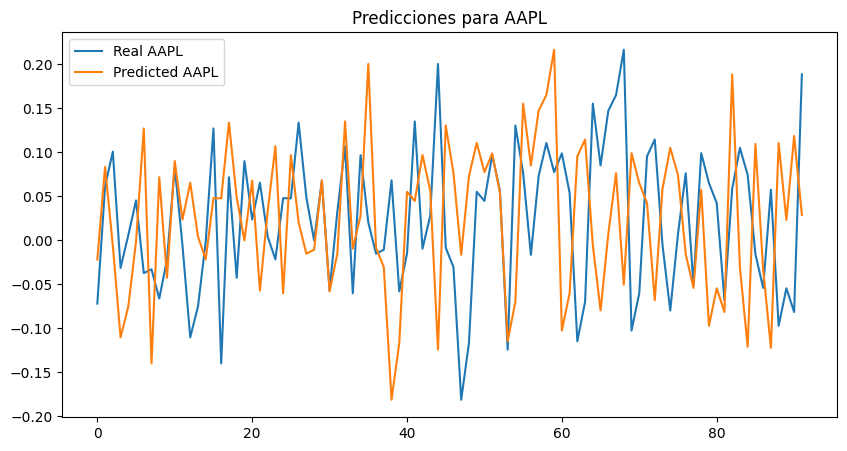

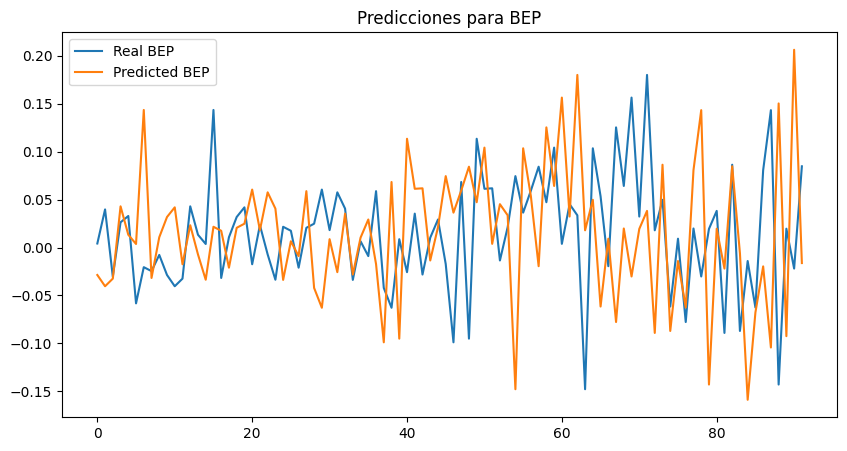

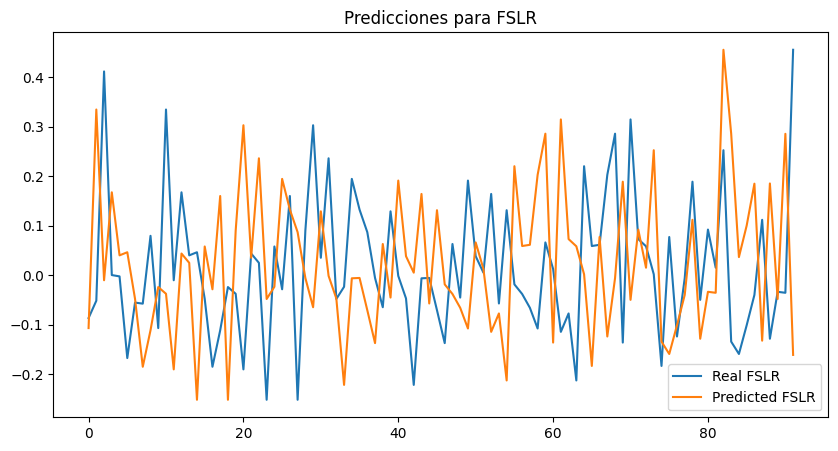

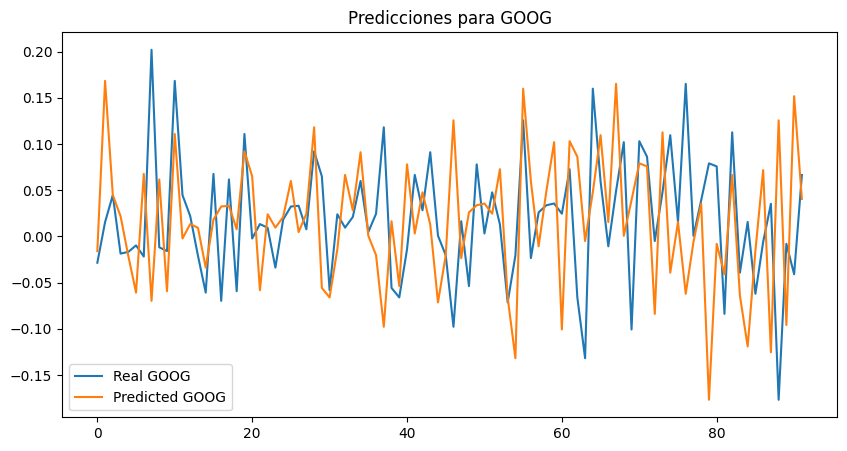

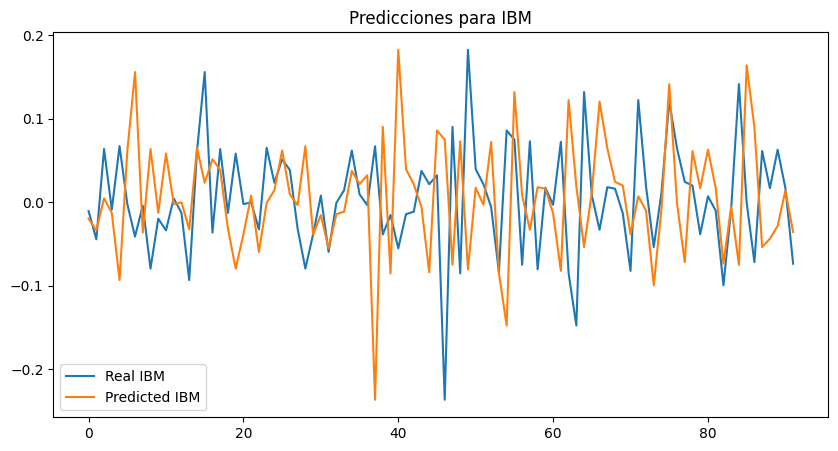

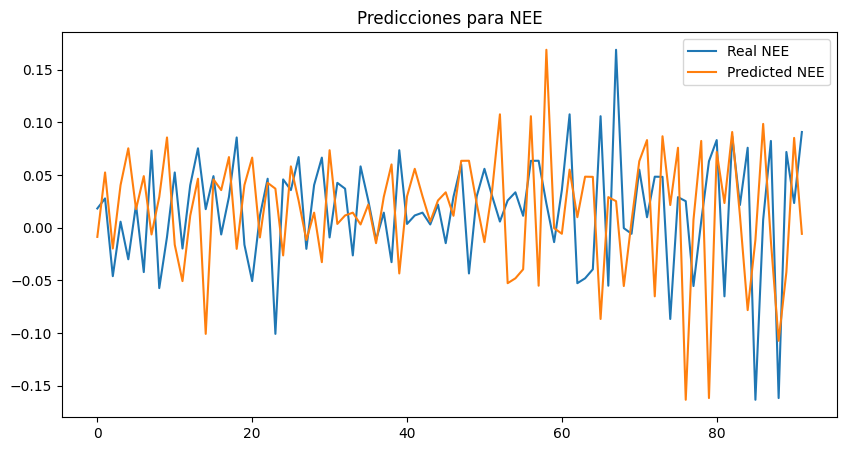

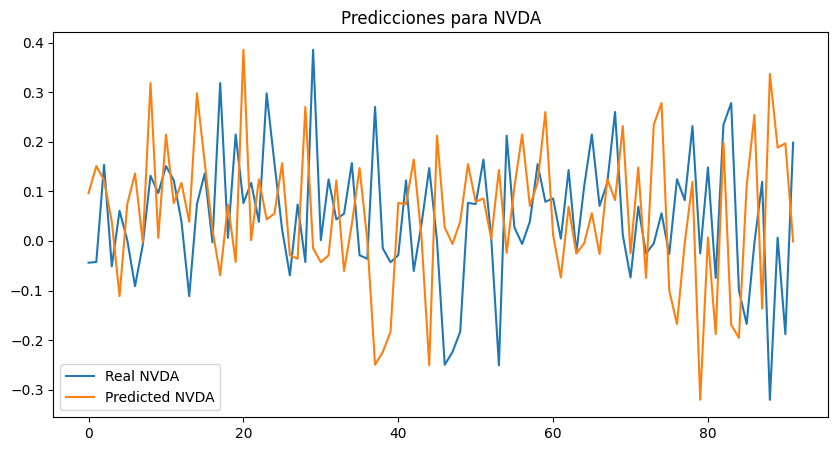

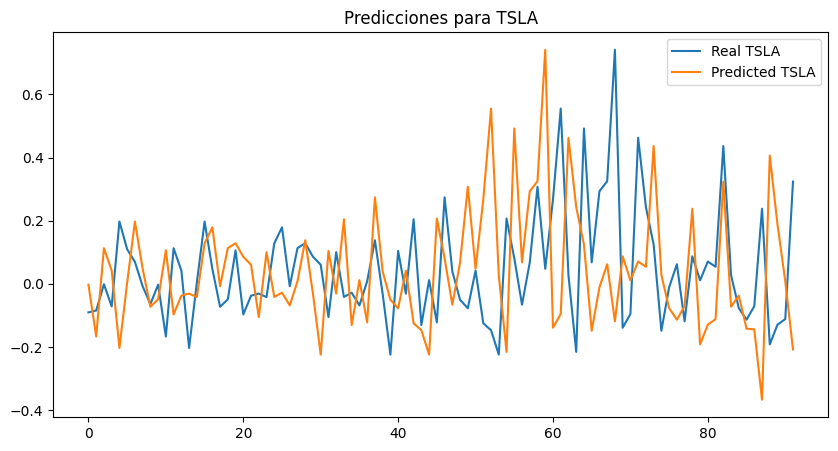

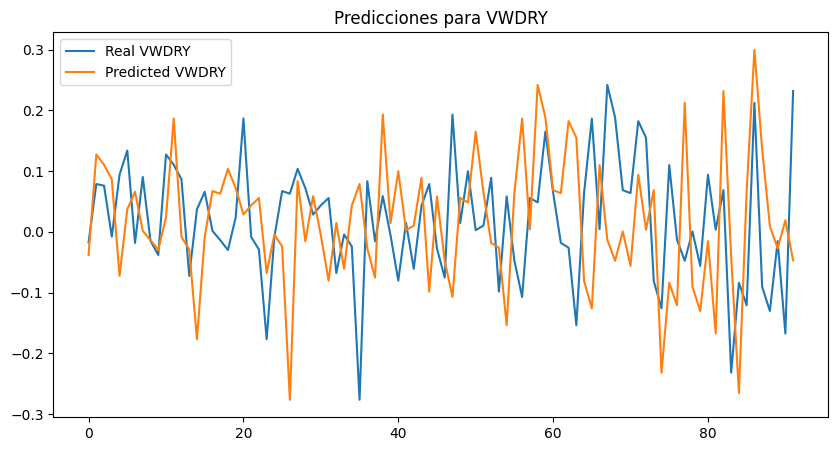

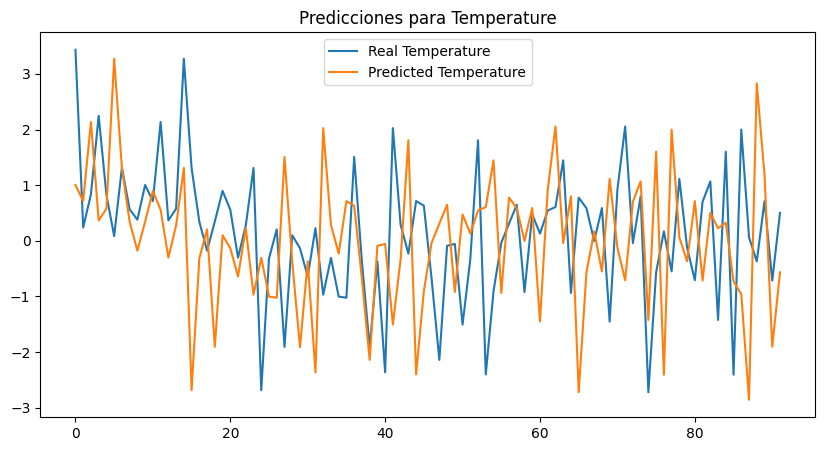

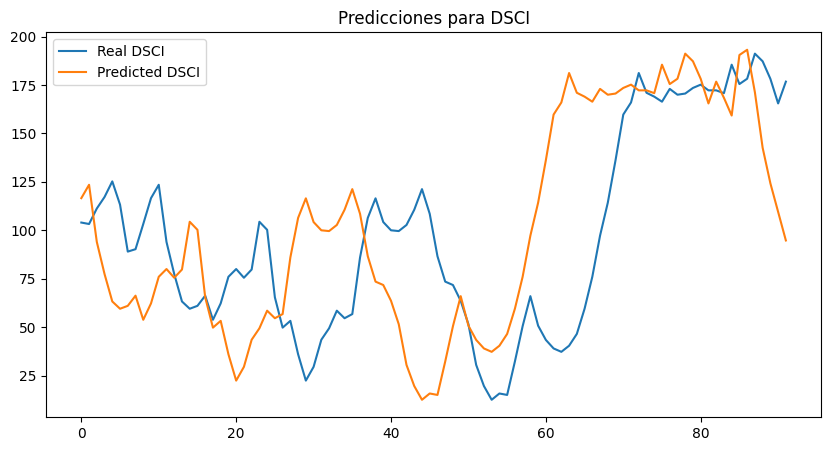

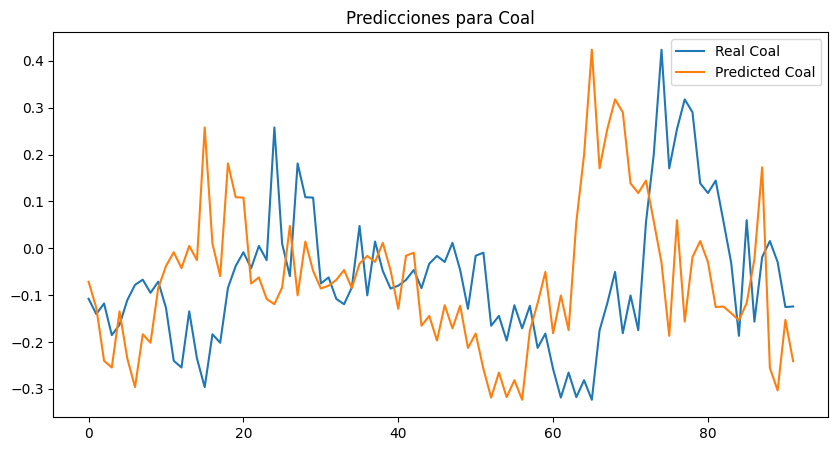

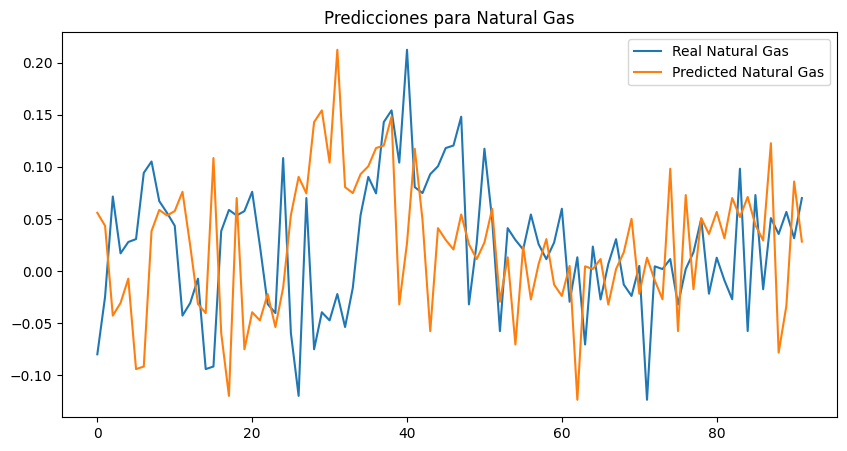

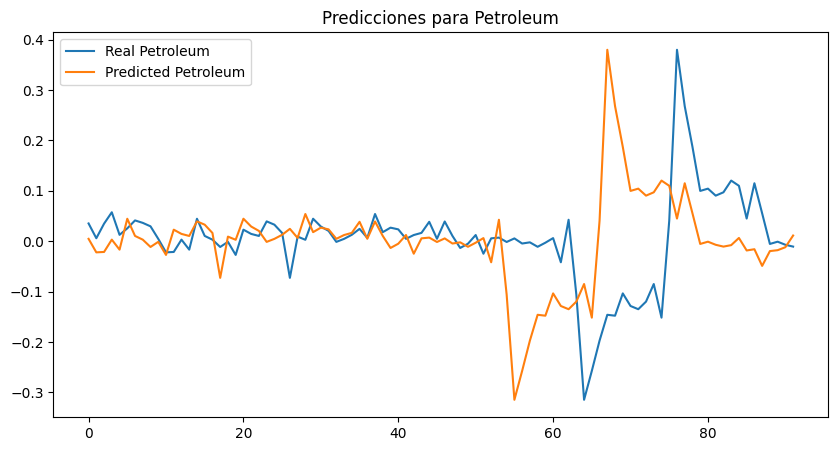

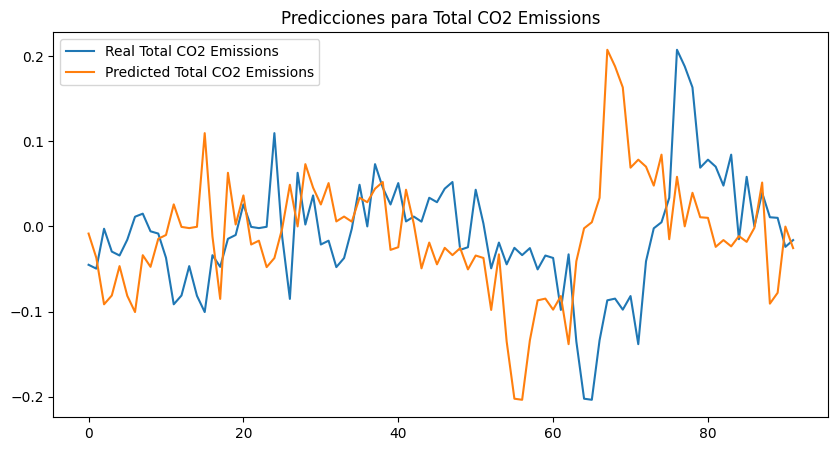

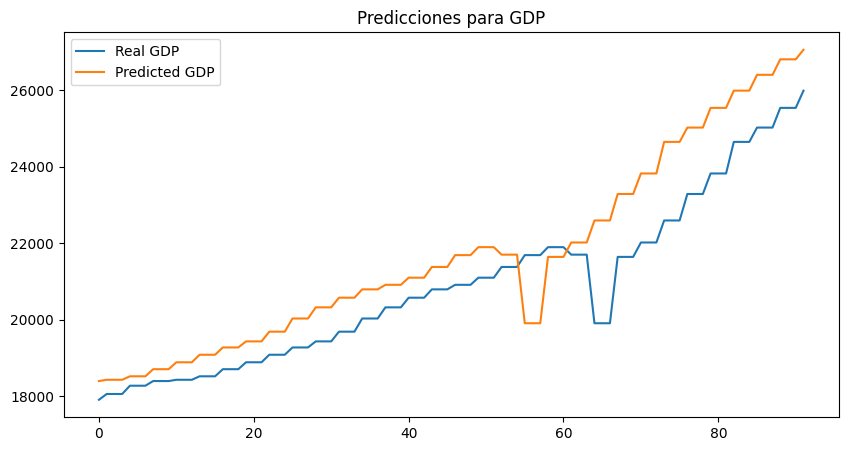

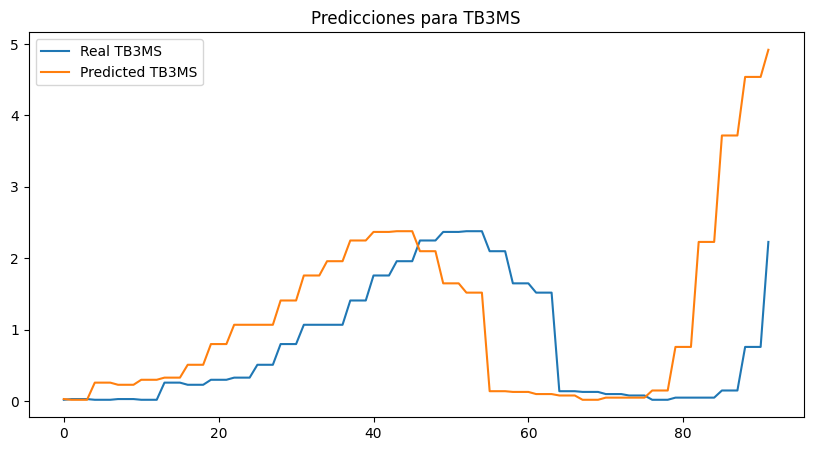

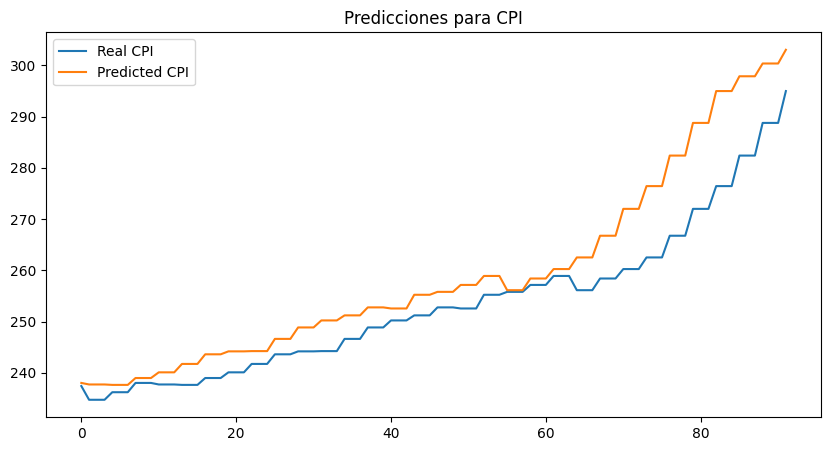

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

In [5]:
# Implementación para la generación de portafolios
def generate_portfolios_with_climate_and_economic_data(all_data, asset_returns, benchmark_returns, risk_free_rate, strategy="sharpe"):
    """
    Genera portafolios utilizando datos financieros, climáticos y económicos,
    y optimiza el portafolio basado en la estrategia seleccionada (Sharpe, Sortino, Omega).
    
    :param all_data: DataFrame con todos los datos combinados (financieros, climáticos y económicos).
    :param asset_returns: DataFrame con los retornos históricos de los activos financieros.
    :param benchmark_returns: DataFrame con los retornos del benchmark (índice o tasa libre de riesgo).
    :param risk_free_rate: Tasa libre de riesgo.
    :param strategy: Estrategia de optimización ("sharpe", "sortino", "omega").
    :return: Pesos óptimos del portafolio.
    """
    # Filtrar las columnas que corresponden a los activos (acciones) y que serán las únicas con pesos asignados
    financial_columns = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP']  # Ejemplo
    
    # Retornos de los activos financieros correspondientes
    asset_data = all_data[financial_columns]
    
    # Inicializar optimizador de portafolios con la estrategia seleccionada
    optimizer = PortfolioOptimizer(asset_returns, benchmark_returns, risk_free_rate)
    
    # Optimizar el portafolio para la estrategia seleccionada
    optimal_weights = optimizer.optimize_portfolio(strategy=strategy)
    print(f"Pesos óptimos del portafolio ({strategy}):", optimal_weights)
    
    # Devuelve los pesos óptimos
    return optimal_weights

# Supongamos que ya has ajustado el modelo VAR y generado los datos de retornos:
# expected_returns y cov_matrix provienen de las predicciones VAR.
# Valores de ejemplo:
risk_free_rate = 0.065  # Tasa libre de riesgo ajustable
benchmark_returns = all_data[['Benchmark']]  # Benchmark returns
asset_returns = all_data[financial_columns]  # Retornos de los activos financieros

# Generación de portafolios y optimización con diferentes estrategias
optimal_weights_sharpe = generate_portfolios_with_climate_and_economic_data(all_data, asset_returns, benchmark_returns, risk_free_rate, strategy="sharpe")
optimal_weights_sortino = generate_portfolios_with_climate_and_economic_data(all_data, asset_returns, benchmark_returns, risk_free_rate, strategy="sortino")
optimal_weights_omega = generate_portfolios_with_climate_and_economic_data(all_data, asset_returns, benchmark_returns, risk_free_rate, strategy="omega")


KeyError: "None of [Index(['Benchmark'], dtype='object')] are in the [columns]"